## Загрузка необходимых библиотек

In [1]:
# Импорт стандарнтых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
%matplotlib inline

# Импорт дополнительных библиотек
import sys
sys.path.append('../../')

import TSLib.models.utils as utils

## Определение констант

In [2]:
seq_lenght = 288 # Длинна временной последовательнсоти
batch_size=128 # размер батча
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Устройство вычисления
device

device(type='cuda')

## Данные
Загрузка датасета без аномалий в датафрейм pandas

In [3]:
df = pd.read_csv('../../data/NAB/artificialNoAnomaly/art_daily_small_noise.csv', sep=',', index_col='timestamp', parse_dates=True)

Нормализация датафрейма

In [4]:
scaler = MinMaxScaler()
scaler.fit(df)
norm_df = scaler.transform(df)

Создание даталоадера тестовых данных

In [5]:
X, y = utils.create_sequences(norm_df, seq_lenght)
_, X, _, y = utils.train_test_split(X, y, test_size=1)
loader = utils.create_loader(X, y, batch_size, shuffle=False)

## Модель
Загрузка модели LSTM

In [6]:
model = torch.load('../../TSLib/models/trained_models/LSTM_NAB.model').to(device)
model

LSTM(
  (lstm): LSTM(1, 100, num_layers=2, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (activat): ReLU()
)

## Атака на модель машинного обучения
Загрузка библиотеки атаки

In [7]:
from TSLib.attacks.iFGSMTS import IFGSMTS

In [8]:
loss_fn=torch.nn.MSELoss()
ifgsm = IFGSMTS(model, loss_fn, device)

## Проведение атаки для разных значений Eps

In [9]:
eps__max_size = 0.1
eps_step = 0.01
eps_list = np.arange(0, eps__max_size+eps_step, eps_step)
loss_fn = torch.nn.MSELoss()
n_iter = 20

allval_mse_list, oneval_mse_list = [], []
for eps in eps_list:
    allval_mse, oneval_mse = [], []
    for X, y in loader:                 
        
        X_adv_untarget_allval = ifgsm.attack(X, y, eps, num_steps=10, targeted=False, num_elem = None)
        X_adv_untarget_oneval = ifgsm.attack(X, y, eps, num_steps=10, targeted=False, num_elem = 1)

        for _ in range(n_iter):
            with torch.no_grad():
                y_adv_pred_allval = model(X_adv_untarget_allval.to(device)).to(device)
                y_adv_pred_oneval = model(X_adv_untarget_oneval.to(device)).to(device)

            allval_mse.append(
                            mean_squared_error(
                                                y.detach().numpy(), 
                                                y_adv_pred_allval.cpu().detach().numpy()
                                                )
                            )
            oneval_mse.append(mean_squared_error(y.detach().numpy(), y_adv_pred_oneval.cpu().detach().numpy()))

    allval_mse_list.append(np.mean(allval_mse))
    oneval_mse_list.append(np.mean(oneval_mse))

    print(f'Eps = {eps}       MSE (all elements TS) = {np.mean(allval_mse):.4f}       MSE (one element TS) = {np.mean(oneval_mse):.4f}')

Eps = 0.0       MSE (all elements TS) = 0.0058       MSE (one element TS) = 0.0058
Eps = 0.01       MSE (all elements TS) = 0.0065       MSE (one element TS) = 0.0062
Eps = 0.02       MSE (all elements TS) = 0.0075       MSE (one element TS) = 0.0067
Eps = 0.03       MSE (all elements TS) = 0.0087       MSE (one element TS) = 0.0073
Eps = 0.04       MSE (all elements TS) = 0.0101       MSE (one element TS) = 0.0080
Eps = 0.05       MSE (all elements TS) = 0.0117       MSE (one element TS) = 0.0087
Eps = 0.06       MSE (all elements TS) = 0.0135       MSE (one element TS) = 0.0096
Eps = 0.07       MSE (all elements TS) = 0.0155       MSE (one element TS) = 0.0105
Eps = 0.08       MSE (all elements TS) = 0.0177       MSE (one element TS) = 0.0115
Eps = 0.09       MSE (all elements TS) = 0.0202       MSE (one element TS) = 0.0125
Eps = 0.1       MSE (all elements TS) = 0.0229       MSE (one element TS) = 0.0137


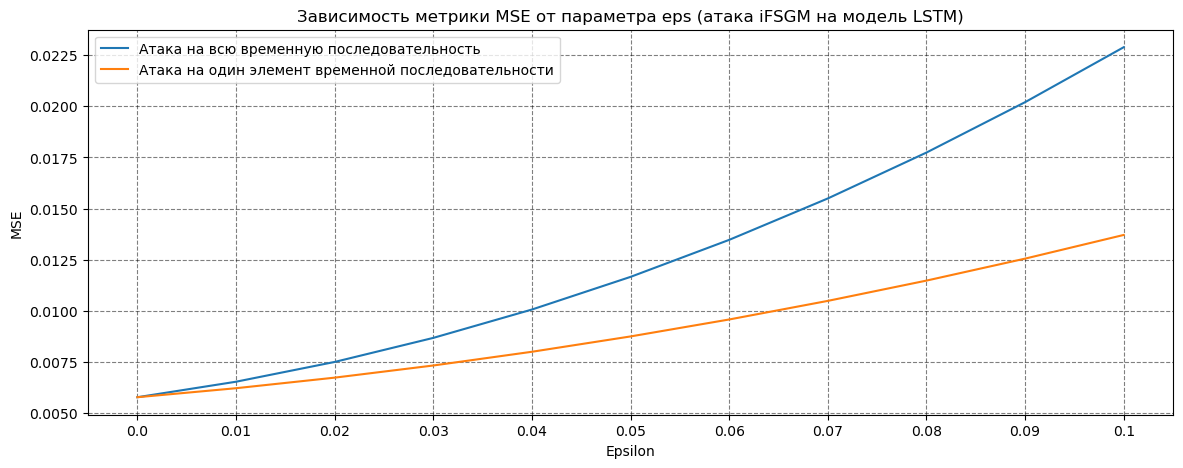

In [10]:
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(111)
plt.plot(allval_mse_list, label='Атака на всю временную последовательность')
plt.plot(oneval_mse_list, label='Атака на один элемент временной последовательности')   
plt.xlabel('Epsilon')
plt.ylabel('MSE')
plt.xticks(np.arange(0, len(eps_list)), eps_list)
plt.legend()
plt.title("Зависимость метрики MSE от параметра eps (атака iFSGM на модель LSTM)")
ax.grid(True, which='major', color='k', linestyle='dashed', alpha=0.5)
plt.show()